#### set up packages, load path

In [1]:
on_work_computer = false;

project_folder = "/Users/erussek/Dropbox/meg_behavior";

plot_folder = "$project_folder/model_fitting/paper_plots"

using CSV

using DataFrames
using DataFramesMeta
using CategoricalArrays # for making data categorical
using Statistics # for median
using StatsBase # for mad
using Gadfly # for plotting
using Cairo # for plotting
using Fontconfig # for plotting
using MixedModels # for linear mixed effects models
using GLM
using StatsBase

include("descriptive.jl")


plot_choice_sim_data_comp_safe (generic function with 1 method)

### Get subjects, assign numeric IDs

In [2]:
data_raw = CSV.read("$project_folder/data/meg_online_recognition_task_ver2.csv", DataFrame);
data_raw.sub = CategoricalArray(groupindices(groupby(data_raw,:subjectID)));

NS_total = length(unique(data_raw.subjectID));

## Look at choice data

In [3]:
## Look at choice data
data = @linq data_raw |> 
        where(:block_number .> 7, :phase .== "TEST", :trial_type .== "evan-run-trial") |>
        select(:subjectID, :block_number, :safe_val_actual, :safe_val_base, :trigger_val_actual,
        :trigger_val_base, :other_noise, :o1_trigger, :gl_type, :accept, :rt, :phase, :p_trigger,
        :p_o1, :o1_val, :o2_val, :safe_val, :outcome_reached, :choice_number, :trial_number, :recognition_number, :correct_recognition,
        :o1_image, :o2_image, :safe_image, :stim_pos_y, :sub);
subs = unique(data.sub)

choice_subs = unique(data.sub);

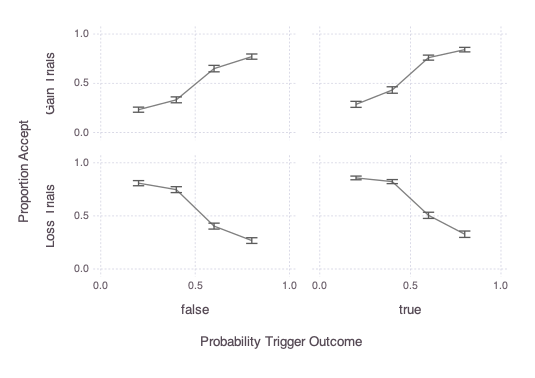

In [4]:
task_data = data[(data.block_number.>7), :];
choice_data = @subset(task_data, :recognition_number .== 0, :accept .!= "NA")
choice_data.accept = parse.(Float64,choice_data.accept)

function make_agg_accept_data2(data)
    data.gs_diff = (data.o1_val .+ data.o2_val)./2 - data.safe_val_actual;
    data[!,:gs_pos] = data.gs_diff .> 0;
    data[!,:frame] .= "Loss Trials";
    data.frame[data.safe_val_actual .> 0] .= "Gain Trials"
    all_s_accept_data = combine(groupby(data, [:sub, :frame, :gs_pos, :p_trigger]), df -> DataFrame(accept = mean(df.accept)))
    agg_accept_data = combine(groupby(all_s_accept_data, [:gs_pos, :frame, :p_trigger]), 
        df -> DataFrame(accept = mean(df.accept), 
            accept_upper = mean(df.accept) + sem(df.accept), 
            accept_lower = mean(df.accept) - sem(df.accept)));
    return agg_accept_data
end

agg_accept_data = make_agg_accept_data2(@subset(choice_data,:sub .!= 4, :sub .!= 7));

p_gain = plot(agg_accept_data ,x = :p_trigger, #group = :safe_val_base_cat,
            xgroup = :gs_pos, ygroup = :frame,
                Scale.xgroup(levels = unique(sort(agg_accept_data.gs_pos))),
                Scale.ygroup(levels = unique(sort(agg_accept_data.frame))),
            Geom.subplot_grid(
                layer(agg_accept_data, y = :accept, ymin = :accept_lower, ymax = :accept_upper, Geom.errorbar(), Geom.line(), Theme(default_color=colorant"grey", line_width = 1pt)),
        Guide.xticks(ticks = [0, .5, 1]),
        Guide.yticks(ticks = [0, .5, 1]),
        ),
        Guide.ylabel("Proportion Accept"),
        Guide.xlabel("Probability Trigger Outcome"),
        Guide.title(""),
        Theme(major_label_font_size=10pt, minor_label_font_size=8pt))

draw(PNG(),p_gain)

# remove subjs who accepted more than 80% or rejected more than 80%

function get_prop_accept(sub_data)

    return sum(sub_data.accept)/length(sub_data.accept)
end

p_accept_data = combine(groupby(choice_data, :sub), get_prop_accept)

bad_accept_sub = unique(p_accept_data.sub[p_accept_data.x1 .> .8])
bad_reject_sub = unique(p_accept_data.sub[p_accept_data.x1 .< .2])

NS_post_ba = length(unique(choice_data.sub));


### Plot subset of subjects

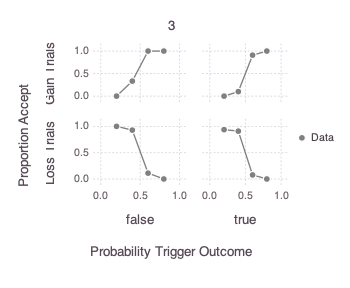

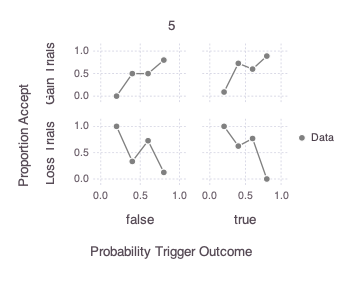

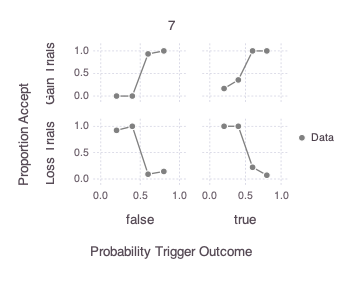

In [5]:
function make_s_agg_accept_data2(data)
    data.gs_diff = (data.o1_val .+ data.o2_val)./2 - data.safe_val_actual;
    data[!,:gs_pos] = data.gs_diff .> 0;
    data[!,:frame] .= "Loss Trials";
    data.frame[data.safe_val_actual .> 0] .= "Gain Trials"
    all_s_accept_data = combine(groupby(data, [:sub, :frame, :gs_pos, :p_trigger]), df -> DataFrame(accept = mean(df.accept)))
    return all_s_accept_data
end


for s_num in [3,5,7]#unique(choice_data.sub)
    #print(string("sub: ", s_num, :))
    s_data = choice_data[choice_data.sub.==s_num,:]
    agg_accept_data = make_s_agg_accept_data2(choice_data[choice_data.sub.==s_num,:]);


    p = plot(@subset(agg_accept_data, :sub .== s_num) ,x = :p_trigger,
                xgroup = :gs_pos, ygroup = :frame,
                Scale.xgroup(levels = unique(sort(agg_accept_data.gs_pos))),
                
                Scale.ygroup(levels = unique(sort(agg_accept_data.frame))),
                Geom.subplot_grid(
                    layer(@subset(agg_accept_data, :sub .== s_num), y = :accept, Geom.point(), Geom.line(), Theme(default_color=colorant"grey", line_width = 1pt)),
            Guide.xticks(ticks = [0, .5, 1]),
            Guide.yticks(ticks = [0, .5, 1]),
            ),
            Guide.ylabel("Proportion Accept"),
            Guide.xlabel("Probability Trigger Outcome"),
            Guide.title(string(s_num)),
            Guide.manual_color_key("", ["Data"], ["grey"]),
            Theme(major_label_font_size=10pt, minor_label_font_size=8pt)) 

    draw(PNG(3.65inch, 3inch),p)
end

#### Load model fits

In [6]:
### load fitted parameters
add_param_path = "$project_folder/Recognition_Task/add_params_recog.csv"
add_param_df = CSV.read(add_param_path,DataFrame)

pros_param_path = "$project_folder/Recognition_Task/pros_params_recog.csv"
pros_param_df = CSV.read(pros_param_path,DataFrame);


### Load BIS data

In [7]:
bis_df = CSV.read("$project_folder/questionnaire_analysis/recog_questionnaire_scores_wide.csv", DataFrame);

#### Set recognition data

In [8]:
recog_data = @subset(data, :recognition_number .> 0, .!ismissing.(:rt))



# set the probability of the probed item (recognition_number)

recog_data.p_o2 = 1 .- recog_data.p_o1;
# for recog = 1, it's p_o1
recog_data.probe_prob = copy(recog_data.p_o1)

# for recog = 2, it's p_o2
recog_data.probe_prob[recog_data.recognition_number .== 2] = recog_data.p_o2[recog_data.recognition_number .== 2];
recog_data.probe_prob .= recog_data.probe_prob .- .5

# for recog = 3, it's 0
recog_data.probe_prob[recog_data.recognition_number .== 3] .= 0

# set the reward regressor
# for 1, it's 1 minus 2
recog_data.r_diff_o1 = abs.(recog_data.o1_val) - abs.(recog_data.o2_val)
recog_data.r_diff = copy(recog_data.r_diff_o1)

# for 2, it's -1 times this (this was wrong)
recog_data.r_diff[recog_data.recognition_number .== 2] = -1 .*recog_data.r_diff_o1[recog_data.recognition_number .== 2];

# for 3 it's 0
recog_data.r_diff[recog_data.recognition_number .== 3] .= 0

recog_data.probe_rew = recog_data.r_diff


# set the probed image
# for 1, it's o1
recog_data.probed_image = copy(recog_data.o1_image)

# for 2, it's o2
recog_data.probed_image[recog_data.recognition_number .== 2] .= recog_data.o2_image[recog_data.recognition_number .== 2];

# for 3 it's the safe
recog_data.probed_image[recog_data.recognition_number .== 3] .= recog_data.safe_image[recog_data.recognition_number .== 3];

#
recog_data.probe_safe = recog_data.recognition_number .== 3;

In [9]:
recog_data_w_params = leftjoin(recog_data,add_param_df,on=:sub);
recog_data_w_params = leftjoin(recog_data_w_params,pros_param_df,on=:sub);

recog_data_w_params = @subset(recog_data_w_params, .!ismissing.(:rt))
bad_rt_subs = []
for br in bad_accept_sub
    recog_data_w_params = @subset(recog_data_w_params, :sub .!= br)
end

for br in bad_reject_sub
    recog_data_w_params = @subset(recog_data_w_params, :sub .!= br)
end


#### Run regressions to measure effect of rewards and probability on response timnes

In [10]:
recog_data_w_params_bis = leftjoin(recog_data_w_params, bis_df, on=:subjectID);

rt_prob = []
rt_rew = []
rt_safe= []
BIS = []
choice_prob = []
choice_rew = []
subs = []

gammas = []
deltas = []
u_powers = []

for s in unique(recog_data_w_params_bis.sub)
    s_data = @subset(recog_data_w_params_bis, :sub .== s)
    s_data[!,:log_rt] = log.(s_data.rt)
    this_res = lm(@formula(log_rt ~  probe_prob + probe_rew + probed_image), s_data)

    push!(rt_prob,coef(this_res)[2])
    push!(rt_rew,coef(this_res)[3])    

    push!(BIS,s_data.BIS[1])
    push!(choice_prob, s_data.beta_prob[1])
    push!(choice_rew, s_data.beta_rew[1])
    push!(subs, s_data.sub[1])
    
    push!(gammas, s_data.gamma[1])
    push!(deltas,s_data.delta[1])
    push!(u_powers, s_data.u_power[1])
    

end



#### Measure relationships with choice vars

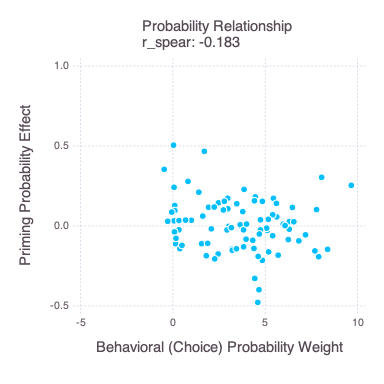

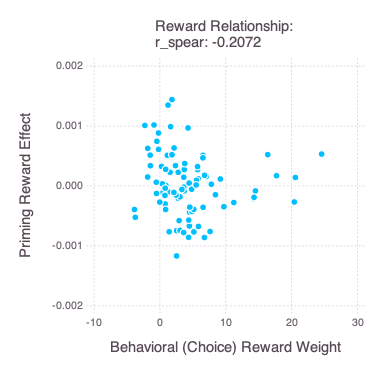

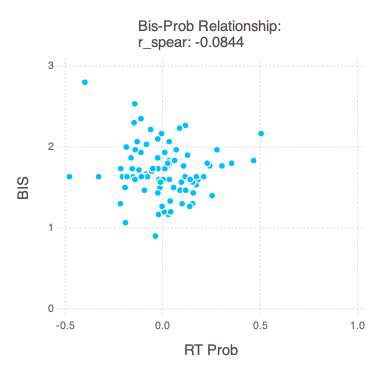

In [11]:
this_corr_spear = corspearman(Float64.(rt_prob), Float64.(choice_prob))
p=plot(x=choice_prob,y=rt_prob, 
    Guide.xlabel("Behavioral (Choice) Probability Weight"), Guide.ylabel("Priming Probability Effect"), 
    Guide.title(string.("Probability Relationship \nr_spear: ", round(this_corr_spear, digits = 4))),
    Geom.point(),
    Theme(point_shapes=[Shape.circle])
)

draw(PNG(4inch,4inch),p)
draw(SVG("$plot_folder/rt_prob_prob.svg", 3.5inch,3.5inch),p)

this_corr_spear = corspearman(Float64.(rt_rew), Float64.(choice_rew))

p=plot(x=choice_rew,y=rt_rew,  Guide.xlabel("Behavioral (Choice) Reward Weight"), Guide.ylabel("Priming Reward Effect"), 
    Guide.title(string.("Reward Relationship: \nr_spear: ", round(this_corr_spear, digits = 4))))
draw(PNG(4inch,4inch),p)
draw(SVG("$plot_folder/rt_rew_rew.svg", 3.5inch,3.5inch),p)

good_bis = .!ismissing.(BIS)

this_corr_spear = corspearman(Float64.(rt_prob[good_bis]), Float64.(BIS[good_bis]))

p=plot(x=rt_prob,y=BIS, Guide.xlabel("RT Prob"), Guide.ylabel("BIS"), 
    Guide.title(string.("Bis-Prob Relationship: \nr_spear: ", round(this_corr_spear, digits = 4))))
draw(PNG(4inch,4inch),p)
draw(SVG("$plot_folder/rt_prob_bis.svg", 3.5inch,3.5inch),p);

